# Hour Detection

In [ ]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import math

#my functions
from Plot import plot_cv, plot_img

In [281]:
path = '../../../Data/data-resampled/clock_0540.png' 
img_color = cv.imread(path, cv.IMREAD_COLOR_RGB)
img = cv.cvtColor(img_color, cv.COLOR_RGB2GRAY)
img.shape

(500, 800)

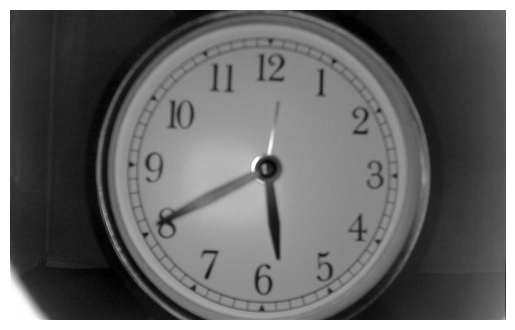

In [282]:
plot_img(img)

In [283]:
blur = cv.GaussianBlur(img, (7,7), 0)

## EDA

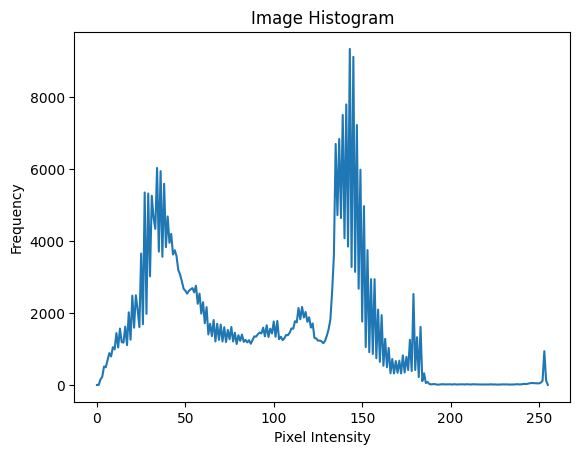

In [284]:
hist = cv.calcHist([img], [0], None, [256], [0, 256])
plt.plot(hist)
plt.title('Image Histogram')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')
plt.show()

https://www.6sigma.us/six-sigma-in-focus/bimodal-histogram/

## Binarize Image

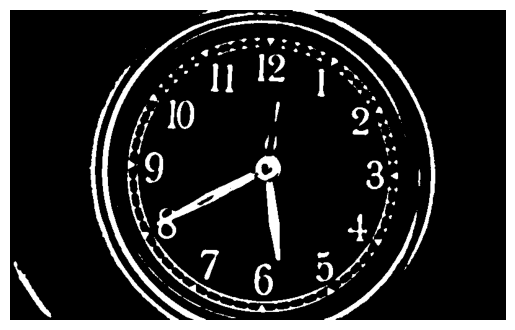

In [285]:
th = cv.adaptiveThreshold(blur, 255, cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY, 41, 11)
th = cv.bitwise_not(th)
plot_img(th)

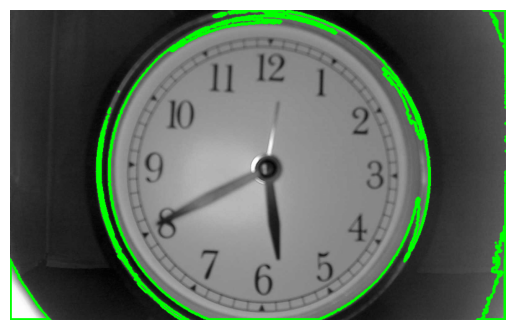

In [286]:
_, th3 = cv.threshold(img, 0, 255, cv.THRESH_BINARY+cv.THRESH_OTSU)
cnts, _ = cv.findContours(th3, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
cv.drawContours(img_color, cnts, -1, (0, 255, 0), 3)
plot_img(img_color)

## Find Circle (X, Y) and Radius

In [287]:
def find_center_radius_contour(gray):
    H, W = gray.shape[:2]
    cx0, cy0 = W//2, H//2

    mask = np.zeros_like(gray, np.uint8)
    cv.circle(mask, (cx0, cy0), int(0.48*min(H, W)), 255, -1)

    _, th = cv.threshold(gray, 0, 255, cv.THRESH_BINARY+cv.THRESH_OTSU)
    th = cv.bitwise_and(th, mask)

    cnts, _ = cv.findContours(th, cv.RETR_LIST, cv.CHAIN_APPROX_SIMPLE)

    best, best_score = None, -1.0
    for c in cnts:
        area = cv.contourArea(c)
        if area < 5_000:  
            continue
        peri = cv.arcLength(c, True)
        if peri == 0:
            continue
        circ = 4*np.pi*area/(peri*peri)          
        (x,y), r = cv.minEnclosingCircle(c)

        center_pen = 1.0 / (1.0 + np.hypot(x-cx0, y-cy0))
        score = circ * np.sqrt(area) * center_pen

        if score > best_score:
            best_score, best = score, (int(x), int(y), int(r))

    return best

In [288]:
cx, cy, r = find_center_radius_contour(img)

In [289]:
def mask_inner_disk(shape, cx, cy, r, inner=0.90, outer=0.98):
    h, w = shape
    mask = np.zeros((h, w), np.uint8)
    cv.circle(mask, (cx, cy), int(r*inner), 255, -1, cv.LINE_AA)
    rim = np.zeros((h, w), np.uint8)
    cv.circle(rim, (cx, cy), int(r*outer), 255, -1, cv.LINE_AA)
    cv.circle(rim, (cx, cy), int(r*inner), 0, -1, cv.LINE_AA)
    return mask, rim

In [ ]:
mask_disk, mask_rim = mask_inner_disk(img.shape, cx, cy, r)
bin_inner = cv.bitwise_and(th, mask_disk)

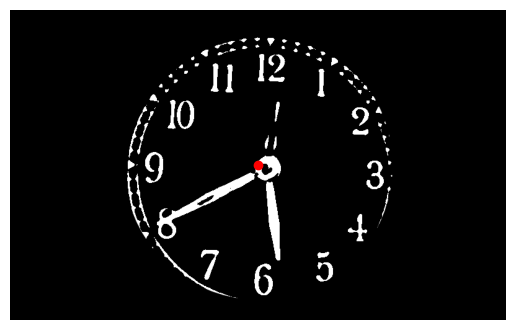

In [291]:
plt.imshow(bin_inner, cmap = plt.cm.gray)
plt.plot(cx, cy, 'ro')
plt.axis('off')
plt.show()

## Find Hands of the Clock

In [292]:
def find_hands(bin_img, cx, cy, r, rin_frac=0.16, rout_frac=0.97, gap_frac=0.01, fan=1):
    h, w = bin_img.shape
    R = int(r)
    rin  = int(R * rin_frac)     
    rout = int(R * rout_frac)   
    gap_tol = max(1, int(R * gap_frac))

    response = np.zeros(360, np.float32)
    end_r    = np.zeros(360, np.int32)

    for ang in range(360):
        best, best_end = 0, rin
        cur, gaps      = 0, 0

        angs = [ (ang + d) % 360 for d in range(-fan, fan+1) ]

        for rr in range(rin, rout):
            is_white = False
            for a in angs:
                theta = math.radians(a)
                x = int(round(cx + rr * math.cos(theta)))
                y = int(round(cy + rr * math.sin(theta)))
                if 0 <= x < w and 0 <= y < h and bin_img[y, x] > 127: 
                    is_white = True
                    break

            if is_white:
                cur += 1 + gaps
                gaps = 0
            else:
                if cur > 0 and gaps < gap_tol:
                    gaps += 1
                else:
                    if cur > best:
                        best = cur
                        best_end = rr - 1
                    cur, gaps = 0, 0

        if cur > best:
            best = cur
            best_end = rout - 1

        response[ang] = best
        end_r[ang] = best_end

    return response, end_r


In [ ]:
response, end_r = find_hands(bin_inner, cx, cy, r)

In [294]:
def ang_dist_deg(a, b):
    d = abs((a - b) % 360.0)
    return d if d <= 180.0 else 360.0 - d #min distance

def top2_peaks_circular(response, nms_window_deg=18):
    resp = np.asarray(response, np.float32)
    idx_sorted = np.argsort(resp)[::-1]
    taken = []

    def circ_dist(a, b):
        d = abs((a - b) % 360)
        return d if d <= 180 else 360 - d

    for i in idx_sorted:
        a = int(i) % 360
        if all(circ_dist(a, t) > nms_window_deg for t in taken):
            taken.append(a)
            if len(taken) == 2:
                break
    taken.sort()
    return taken 

In [295]:
peaks = top2_peaks_circular(response, nms_window_deg=18)
peaks

[76, 147]

## Convert the Angles to Time

In [296]:
def ang_norm_deg(a):
        return float(a) % 360.0

def angles_to_time(angles, lengths, r):
        if len(angles) < 2: 
            return None, None
        
        Lnorm = [l / max(1.0, float(r)) for l in lengths]
        idx_min = int(np.argmax(Lnorm))       #minutes is the most longer
        idx_hr  = 1 - idx_min

        aM = ang_norm_deg(angles[idx_min])
        aH = ang_norm_deg(angles[idx_hr])

        phiM = ang_norm_deg(aM + 90.0)
        phiH = ang_norm_deg(aH + 90.0)

        M = int(round(phiM / 6.0)) % 60
        hour_float = ((phiH - 0.5 * M) / 30.0) % 12.0
        H = int(round(hour_float)) % 12
        H = 12 if H == 0 else H
        return H, M

In [297]:
lengths = [response[p] for p in peaks]
H, M = angles_to_time(peaks, lengths, r)

## Draw the Lines in the Image

In [298]:
def draw(base_gray, cx, cy, angles, lengths, r):
        out = cv.cvtColor(base_gray, cv.COLOR_GRAY2BGR)
        for i, ang in enumerate(angles):
            L = int(lengths[i])
            theta = math.radians(ang)
            x2 = int(round(cx + (L + max(3, int(0.02*r))) * math.cos(theta)))
            y2 = int(round(cy + (L + max(3, int(0.02*r))) * math.sin(theta)))
            color = (0,0,255) if i==0 else (255,0,0)
            cv.line(out, (cx, cy), (x2, y2), color, 3, cv.LINE_AA)
            cv.circle(out, (x2, y2), 4, color, -1, cv.LINE_AA)
        cv.circle(out, (cx, cy), 6, (255,255,255), -1, cv.LINE_AA)
        return out

In [299]:
out = draw(img, cx, cy, peaks, lengths, r)

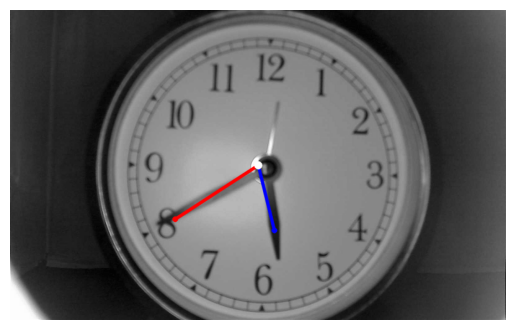

In [300]:
plot_img(out)

## Hour Prediction

In [301]:
print(f"{H:02d}:{M:02d}")

05:40


In [302]:
plot_cv(out)